<a href="https://colab.research.google.com/github/marawangamal/rltn/blob/main/rl_tensor_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install networkx matplotlib
!pip3 install tensornetwork
!pip3 install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.3/364.3 kB 4.5 MB/s eta 0:00:00


# 1. Enivronment

## 1.1 NCON

In [2]:
"""
A module for the ncon function to contract multiple tensors.
References:
    - https://github.com/mhauru/ncon/blob/master/src/ncon/ncon.py
"""

from collections.abc import Iterable
from tqdm import tqdm
import torch


def ncon(tensor_list, edge_list, order=None, forder=None, check_indices=True):
    """
    Args:
        tensor_list:    list of tensors to be contracted
        edge_list:      list of lists of indices e.g. edge_list[0] = [3, 4, -1]
                        labels the three indices of tensor tensor_list[0],
                        with -1 indicating an uncontracted index (open leg)
                        and 3 and 4 being the contracted indices.
        order:          list of contraction order (default [1, 2, 3, 4, ...])
        forder:         list of final ordering (default [-1, -2, ...])
        check_indices:  sanity  check the inputs (default True)

    Returns:
        A: contracted tensor
    """

    # We want to handle the tensors as a list, regardless of what kind
    # of iterable we are given. Inputs are assumed to be non-empty.
    tensor_list = list(tensor_list)
    edge_list = list(edge_list)
    if not isinstance(edge_list[0], Iterable):
        # edge_list is not a list of lists, so make it such.
        edge_list = [edge_list]
    else:
        edge_list = list(map(list, edge_list))

    if order is None:
        order = create_order(edge_list)
    if forder is None:
        forder = create_forder(edge_list)

    if check_indices:
        # Raise a RuntimeError if the indices are wrong.
        do_check_indices(tensor_list, edge_list, order, forder)

    # If the graph is disconnected, connect it with trivial indices that
    # will be contracted at the very end.
    connect_graph(tensor_list, edge_list, order)

    while len(order) > 0:
        tcon = get_tcon(edge_list, order[0])  # tcon = tensors to be contracted
        # Find the indices icon that are to be contracted.
        if len(tcon) == 1:
            tracing = True
            icon = [order[0]]
        else:
            tracing = False
            icon = get_icon(edge_list, tcon)
        # Position in tcon[0] and tcon[1] of indices to be contracted.
        # In the case of trace, pos2 = []
        pos1, pos2 = get_pos(edge_list, tcon, icon)
        if tracing:
            # Trace on a tensor
            new_A = trace(tensor_list[tcon[0]], axis1=pos1[0], axis2=pos1[1])
        else:
            # Contraction of 2 tensors
            new_A = con(tensor_list[tcon[0]], tensor_list[tcon[1]], (pos1, pos2))
        tensor_list.append(new_A)
        edge_list.append(find_newv(edge_list, tcon, icon))  # Add the edge_list for the new tensor
        for i in sorted(tcon, reverse=True):
            # Delete the contracted tensors and indices from the lists.
            # tcon is reverse sorted so that tensors are removed starting from
            # the end of tensor_list, otherwise the order would get messed.
            del tensor_list[i]
            del edge_list[i]
        order = renew_order(order, icon)  # Update order

    vlast = edge_list[0]
    A = tensor_list[0]
    A = permute_final(A, vlast, forder)
    return A


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #


def create_order(edge_list):
    """Identify all unique, positive indices and return them sorted."""
    flat_v = sum(edge_list, [])
    x = [i for i in flat_v if i > 0]
    # Converting to a set and back removes duplicates
    x = list(set(x))
    return sorted(x)


def create_forder(edge_list):
    """Identify all unique, negative indices and return them reverse sorted
    (-1 first).
    """
    flat_v = sum(edge_list, [])
    x = [i for i in flat_v if i < 0]
    # Converting to a set and back removes duplicates
    x = list(set(x))
    return sorted(x, reverse=True)


def connect_graph(tensor_list, edge_list, order):
    """Connect the graph of tensors to be contracted by trivial
    indices, if necessary. Add these trivial indices to the end of the
    contraction order.

    tensor_list, edge_list and order are modified in place.
    """
    # Build ccomponents, a list of the connected components of the graph,
    # where each component is represented by a a set of indices.
    unvisited = set(range(len(tensor_list)))
    visited = set()
    ccomponents = []
    while unvisited:
        component = set()
        next_visit = unvisited.pop()
        to_visit = {next_visit}
        while to_visit:
            i = to_visit.pop()
            unvisited.discard(i)
            component.add(i)
            visited.add(i)
            # Get the indices of tensors neighbouring tensor_list[i].
            i_inds = set(edge_list[i])
            neighs = (
                j for j, j_inds in enumerate(edge_list) if i_inds.intersection(j_inds)
            )
            for neigh in neighs:
                if neigh not in visited:
                    to_visit.add(neigh)
        ccomponents.append(component)
    # If there is more than one connected component, take one of them, a
    # take an arbitrary tensor (called c) out of it, and connect that
    # tensor with an arbitrary tensor (called d) from all the other
    # components using a trivial index.
    c = ccomponents.pop().pop()
    while ccomponents:
        d = ccomponents.pop().pop()
        A_c = tensor_list[c]
        A_d = tensor_list[d]
        c_axis = len(edge_list[c])
        d_axis = len(edge_list[d])
        tensor_list[c] = torch.unsqueeze(A_c, c_axis)
        tensor_list[d] = torch.unsqueeze(A_d, d_axis)
        try:
            dim_num = max(order) + 1
        except ValueError:
            dim_num = 1
        edge_list[c].append(dim_num)
        edge_list[d].append(dim_num)
        order.append(dim_num)
    return None


def get_tcon(edge_list, index):
    """Gets the list indices in tensor_list of the tensors that have index as their
    leg.
    """
    tcon = []
    for i, inds in enumerate(edge_list):
        if index in inds:
            tcon.append(i)
    l = len(tcon)
    # If check_indices is called and it does its work properly then these
    # checks should in fact be unnecessary.
    if l > 2:
        raise ValueError(
            "In ncon.get_tcon, more than two tensors share a contraction "
            "index."
        )
    elif l < 1:
        raise ValueError(
            "In ncon.get_tcon, less than one tensor share a contraction index."
        )
    elif l == 1:
        # The contraction is a trace.
        how_many = edge_list[tcon[0]].count(index)
        if how_many != 2:
            # Only one tensor has this index but it is not a trace because it
            # does not occur twice for that tensor.
            raise ValueError(
                "In ncon.get_tcon, a trace index is listed != 2 times for the "
                "same tensor."
            )
    return tcon


def get_icon(edge_list, tcon):
    """Returns a list of indices that are to be contracted when contractions
    between the two tensors numbered in tcon are contracted.
    """
    inds1 = edge_list[tcon[0]]
    inds2 = edge_list[tcon[1]]
    icon = set(inds1).intersection(inds2)
    icon = list(icon)
    return icon


def get_pos(edge_list, tcon, icon):
    """Get the positions of the indices icon in the list of legs the tensors
    tcon to be contracted.
    """
    pos1 = [[i for i, x in enumerate(edge_list[tcon[0]]) if x == e] for e in icon]
    pos1 = sum(pos1, [])
    if len(tcon) < 2:
        pos2 = []
    else:
        pos2 = [[i for i, x in enumerate(edge_list[tcon[1]]) if x == e] for e in icon]
        pos2 = sum(pos2, [])
    return pos1, pos2


def find_newv(edge_list, tcon, icon):
    """Find the list of indices for the new tensor after contraction of
    indices icon of the tensors tcon.
    """
    if len(tcon) == 2:
        newv = edge_list[tcon[0]] + edge_list[tcon[1]]
    else:
        newv = edge_list[tcon[0]]
    newv = [i for i in newv if i not in icon]
    return newv


def renew_order(order, icon):
    """Returns the new order with the contracted indices removed from it."""
    return [i for i in order if i not in icon]


def permute_final(A, edge_list, forder):
    """Returns the final tensor A with its legs permuted to the order given
    in forder.
    """
    perm = [edge_list.index(i) for i in forder]
    permuted = A.permute(tuple(perm))

    return permuted


def do_check_indices(tensor_list, edge_list, order, forder):
    """Check that
    1) the number of tensors in tensor_list matches the number of index lists in edge_list.
    2) every tensor is given the right number of indices.
    3) every contracted index is featured exactly twice and every free index
       exactly once.
    4) the dimensions of the two ends of each contracted index match.
    """

    # 1)
    if len(tensor_list) != len(edge_list):
        raise ValueError(
            (
                "In ncon.do_check_indices, the number of tensors %i"
                " does not match the number of index lists %i"
            )
            % (len(tensor_list), len(edge_list))
        )

    # 2)
    # Create a list of lists with the shapes of each A in tensor_list.
    shapes = list(map(lambda A: list(A.shape), tensor_list))
    for i, inds in enumerate(edge_list):
        if len(inds) != len(shapes[i]):
            raise ValueError(
                (
                    "In ncon.do_check_indices, len(edge_list[%i])=%i does not match "
                    "the numbers of indices of tensor_list[%i] = %i"
                )
                % (i, len(inds), i, len(shapes[i]))
            )

    # 3) and 4)
    # v_pairs = [[(0,0), (0,1), (0,2), ...], [(1,0), (1,1), (1,2), ...], ...]
    v_pairs = [[(i, j) for j in range(len(s))] for i, s in enumerate(edge_list)]
    v_pairs = sum(v_pairs, [])
    v_sum = sum(edge_list, [])
    # For t, o in zip(v_pairs, v_sum) t is the tuple of the number of
    # the tensor and the index and o is the contraction order of that
    # index. We group these tuples by the contraction order.
    order_groups = [
        [t for t, o in zip(v_pairs, v_sum) if o == e] for e in order
    ]
    forder_groups = [[1 for fo in v_sum if fo == e] for e in forder]
    for i, o in enumerate(order_groups):
        if len(o) != 2:
            raise ValueError(
                (
                    "In ncon.do_check_indices, the contracted index %i is not "
                    "featured exactly twice in edge_list."
                )
                % order[i]
            )
        else:
            A0, ind0 = o[0]
            A1, ind1 = o[1]
            try:
                compatible = tensor_list[A0].compatible_indices(tensor_list[A1], ind0, ind1)
            except AttributeError:
                compatible = tensor_list[A0].shape[ind0] == tensor_list[A1].shape[ind1]
            if not compatible:
                raise ValueError(
                    "In ncon.do_check_indices, for the contraction index %i, "
                    "the leg %i of tensor number %i and the leg %i of tensor "
                    "number %i are not compatible."
                    % (order[i], ind0, A0, ind1, A1)
                )
    for i, fo in enumerate(forder_groups):
        if len(fo) != 1:
            raise ValueError(
                (
                    "In ncon.do_check_indices, the free index %i is not "
                    "featured exactly once in edge_list."
                )
                % forder[i]
            )

    # All is well if we made it here.
    return True


######################################################################
# The following are simple wrappers around pytorch Tensor functions, #
# but may be replaced with fancier stuff later.                      #
######################################################################


def con(A, B, inds):
    return torch.tensordot(A, B, inds)


def trace(tensor, axis1=0, axis2=1):
    """Return summed entries along diagonals.
    If tensor is 2-D, the sum is over the
    diagonal of tensor with the given offset,
    i.e., the collection of elements of the form a[i, i+offset].
    If a has more than two dimensions, then the axes specified by
    axis1 and axis2 are used to determine the 2-D sub-array whose diagonal is
    summed.
    Args:
      tensor: A tensor.
      axis1, axis2: Axis to be used as the first/second axis of the 2D
                    sub-arrays from which the diagonals should be taken.
                    Defaults to second-last/last axis.
    Returns:
      array_of_diagonals: The batched summed diagonals.
    """
    return torch.sum(torch.diagonal(tensor, dim1=axis1, dim2=axis2), dim=-1)

## 1.2 Environment

In [24]:
import copy
import numpy as np
from typing import List
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import tensornetwork as tn
tn.set_default_backend("pytorch") # tensorflow, jax, numpy, symmetric


class Environment:
  def __init__(
      self,
      target_tensor: np.array,
      compression_constraint: float = 1.0,
      gt_graph: np.array = None,
      gt_free_dimensions: np.array = None,
      max_num_nodes: int = 8,
      max_rank: int = 8,
      min_rank: int = 0,
      max_episode_length: int = 100,
      seed=4,
      verbose = False,
      reward_breakdown = False,
      ) -> None:
    """
      Args:
        target_tensor (np.array): Tensor to factorize
        compression_constraint (float): Compression ratio above which a penalty is applied (lower value means more compression)
        gt_graph (Optional[np.array]): Ground truth for plotting
        gt_free_dimensions (Optional[List]): Ground truth for plotting - Hanging legs (e.g. free_dimensions[i] is the free dimension of node[i])
        max_num_nodes (int): Maximum number of nodes in tensor network
        max_rank (int): Maximim rank dimension (to limit state-action space)
        min_rank (int): Minimum rank dimension (to limit state-action space)
        max_episode_length (int): Max time steps
        reward_breakdown (boolean): Whether to return a detailed breakdown of the reward
    """
    # Assert types and value constraints

    assert isinstance(max_num_nodes, int), "max_num_nodes must be an integer"
    assert isinstance(max_rank, int), "max_rank must be an integer"
    assert isinstance(min_rank, int), "min_rank must be an integer"
    assert max_rank >= min_rank, "max_rank must be greater than or equal to min_rank"
    assert max_num_nodes > 0, "max_num_nodes must be greater than 0"
    n_free_legs = len(target_tensor.shape)
    assert n_free_legs >= 2, "Target tensor must be atleast 2d"


    # self.initial_graph = np.eye(n_free_legs, n_free_legs, 1) + np.eye(n_free_legs, n_free_legs, -1)
    self.initial_graph = np.zeros((n_free_legs, n_free_legs))
    self.free_dimensions = np.array([int(d) for d in target_tensor.shape])

    self.target_tensor = target_tensor
    self.compression_constraint = compression_constraint
    self.state = copy.deepcopy(self.initial_graph)
    self.max_num_nodes = max_num_nodes
    self.max_rank = max_rank
    self.min_rank = min_rank
    self.num_steps = 0
    self.max_episode_length = max_episode_length
    self.verbose = verbose
    self.reward_breakdown = reward_breakdown

    self.gt_graph = gt_graph
    self.gt_free_dimensions = gt_free_dimensions


  def seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]

  def reset(self):
    self.state = copy.deepcopy(self.initial_graph)
    self.num_steps = 0
    return self.state

  @staticmethod
  def tn_to_nxgraph(adj_mat, fixed_node_ids):

    G = nx.from_numpy_array(adj_mat)

    for node_id in fixed_node_ids:
        invisible_node_id = f"invisible_{node_id}"
        G.add_node(invisible_node_id, visible=False)
        G.add_edge(node_id, invisible_node_id)

    pos = nx.circular_layout(G)
    node_colors = []
    node_sizes=[]
    for node in G.nodes():
      if 'invisible' in str(node):
        node_colors.append('none')
        node_sizes.append(10)
      elif node in fixed_node_ids:
        node_colors.append('red')
        node_sizes.append(500)
      else:
        node_colors.append('lightblue')
        node_sizes.append(500)
    # node_colors = ['red' if node in fixed_node_ids else 'lightblue' for node in G.nodes() if 'invisible' not in str(node)]
    edge_colors = 'gray'
    node_labels = {n: n for n in G.nodes() if 'invisible' not in str(n)}
    edge_labels = {(i, j): int(adj_mat[i, j]) for i, j in G.edges if 'invisible' not in str(i) + str(j)}

    # Define a fixed, short distance for 'invisible' nodes to be above their corresponding nodes
    short_distance = 0.2  # Adjust this value as needed

    # Adjust positions for invisible nodes
    for node_id in fixed_node_ids:
        invisible_node_id = f"invisible_{node_id}"
        if invisible_node_id in pos:
            visible_node_pos = pos[node_id]
            # Set the 'invisible' node position slightly above the visible node
            pos[invisible_node_id] = (visible_node_pos[0], visible_node_pos[1] + short_distance)

    return G, pos, node_colors, edge_colors, node_labels, edge_labels, node_sizes


  def plot_adjacency_matrix(self):
    # fixed_node_ids = [i for i in range(len(self.initial_graph))]
    # self._plot_nx_tn_graph(self.state, fixed_node_ids)

    # Prepare the subplot
    if self.gt_graph is not None and self.gt_free_dimensions is not None:
        plt.figure(figsize=(6, 3))  # Adjusted for two subplots
        plt.subplot(1, 2, 1)
    else:
        plt.figure(figsize=(3, 3))

    # Plot the state grap
    fixed_node_ids = [i for i in range(len(self.free_dimensions))]
    G, pos, node_colors, edge_colors, node_labels, edge_labels, node_sizes = self.tn_to_nxgraph(self.state, fixed_node_ids)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors)
    nx.draw_networkx_labels(G, pos, labels=node_labels)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("State Graph")  # Title for the state graph


   # Plot the GT graph if it exists
    if self.gt_graph is not None and self.gt_free_dimensions is not None:
        plt.subplot(1, 2, 2)
        gt_fixed_node_ids = [i for i in range(len(self.gt_free_dimensions))]
        G, pos, node_colors, edge_colors, visible_labels, edge_labels, node_sizes = self.tn_to_nxgraph(self.gt_graph, gt_fixed_node_ids)
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors)
        nx.draw_networkx_labels(G, pos, labels=visible_labels)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.title("GT Graph")  # Title for the GT graph

    plt.show()


  @staticmethod
  def add_empty_row_and_column(arr: np.array) -> np.array:
    n_rows, n_cols = arr.shape
    new_arr = np.zeros((n_rows + 1, n_cols + 1))
    new_arr[:n_rows, :n_cols] = arr
    return new_arr

  @staticmethod
  def remove_row_and_column(arr: np.array, index: int) -> np.array:
      assert arr.shape[0] == arr.shape[1], "State array must be a square matrix"
      assert index < arr.shape[0], "Node index out of range"
      new_arr = np.delete(arr, index, axis=0)
      new_arr = np.delete(new_arr, index, axis=1)
      return new_arr

  def remove_unconnected_nodes(self, tensor_network_adj_matrix):
    """Remove unconnected nodes"""
    for i in range(len(tensor_network_adj_matrix)):
      if np.sum(tensor_network_adj_matrix[i]) == 0 and np.sum(tensor_network_adj_matrix[:, i]) == 0:
        return self.remove_unconnected_nodes(self.remove_row_and_column(tensor_network_adj_matrix, i))
    return tensor_network_adj_matrix

  def min_loss(
      self,
      tensor_network_adj_matrix,
      target_tensor,
      n_iterations=1000,
      learning_rate=1e-5
      ):
    """Optimizes randomly initialized tensor network w.r.t `target_tensor`"""
    tensors = []

    # Remove unconnected nodes (except fixed ones)
    # print(f"Before: \n{tensor_network_adj_matrix}")
    # print(f"Before: \n{self.state}")
    tensor_network_adj_matrix = copy.deepcopy(tensor_network_adj_matrix)
    rows, cols = tensor_network_adj_matrix.shape
    n_fixed = len(self.free_dimensions)
    if rows >= n_fixed and cols >= n_fixed:
      identity_matrix = np.eye(n_fixed)
      tensor_network_adj_matrix[:n_fixed, :n_fixed] += identity_matrix

    tensor_network_adj_matrix = self.remove_unconnected_nodes(tensor_network_adj_matrix)

    if rows >= n_fixed and cols >= n_fixed:
      identity_matrix = np.eye(n_fixed)
      tensor_network_adj_matrix[:n_fixed, :n_fixed] -= identity_matrix


    tensor_network_adj_matrix = tensor_network_adj_matrix.astype(int)
    # print(f"After: \n{tensor_network_adj_matrix}")
    # print(f"After: \n{self.state}\n")

    # Generate random tensors (free leg is last dimension)
    for i in range(len(tensor_network_adj_matrix)):
      dims = tensor_network_adj_matrix[i][tensor_network_adj_matrix[i] > 0]
      if i < len(self.free_dimensions):
        dims = np.append(dims, np.array([self.free_dimensions[i]]))
      tensors.append(torch.randn(*dims, requires_grad=True))

    # Specify contraction for ncon engine
    ncon_v = self.adjacency_matrix_to_ncon_format(tensors, tensor_network_adj_matrix)

    # Optimize loss
    min_loss_observed = float('inf')
    optimizer = torch.optim.AdamW(tensors, lr=learning_rate)
    target_tensor = torch.tensor(target_tensor)
    for t in range(n_iterations):
      optimizer.zero_grad()
      contracted_tensor_network = ncon(tensors, ncon_v)
      loss = torch.mean((contracted_tensor_network - target_tensor) ** 2)
      loss.backward()
      optimizer.step()

      if min_loss_observed > loss.item():
        min_loss_observed = loss.item()

      if t % 2000 == 0 and self.verbose:
        # Calculate compression ratio
        n_params_original = torch.tensor([i for i in self.target_tensor.shape]).prod()
        n_params_tn = sum([tens.numel() for tens in tensors])
        compression_loss = n_params_tn / n_params_original
        print("-" * 200)
        print(f"state: \n{self.state}")
        print(f"tensor_network_adj_matrix: \n{tensor_network_adj_matrix}")
        print(f"Tensor shapes: {[t.shape for t in tensors]}")
        print(f"[{t}/{n_iterations}] Loss (reconst.): {loss.item()} | Loss (compr.): {compression} | Best Loss: {min_loss_observed}")
        print("-" * 200)

    # Calculate compression ratio
    n_params_original = torch.tensor([i for i in self.target_tensor.shape]).prod()
    n_params_tn = sum([tens.numel() for tens in tensors])

    compression_loss = n_params_tn / n_params_original
    compression_loss = 1e5 if compression_loss > self.compression_constraint else 0

    return min_loss_observed, compression_loss


  @staticmethod
  def adjacency_matrix_to_ncon_format(tensors, adj_mat):
      """Convert an adjacency matrix to ncon format.

      Args:
          tensors (List): Contains np tensors to be contracted
          adj_mat (np.array): Binary 2D array describing which tensors are connected

      Returns:
          ncon_v (List[List]): List of lists as in ncon
      """
      num_tensors = len(tensors)
      ncon_v = [[] for _ in range(num_tensors)]

      # Label for contracted indices (start from 1)
      label = 1

      # Iterate over upper triangle of adj_mat to avoid duplicate pairs
      for i in range(num_tensors):
          for j in range(i + 1, num_tensors):
              if adj_mat[i, j] >= 1:
                  # If tensors are connected, assign the same positive label
                  ncon_v[i].append(label)
                  ncon_v[j].append(label)
                  label += 1

      # Assign negative labels for free indices
      for i in range(num_tensors):
          # Number of indices in tensor i
          num_indices = tensors[i].ndim

          # If tensor i has more indices than labels, it has free indices
          while len(ncon_v[i]) < num_indices:
              ncon_v[i].append(-label)
              label += 1

      return ncon_v

  def step_action(self, action: str) -> np.array:
    """ Perform an action in the environment.
      Args:
        action (str): One of ['addNode', 'removeNode:index', 'increment:index1:index2', 'decrement:index1:index2']
      Returns:
        state: (np.array) Adjacency matrix describing tensor network graph
    """
    self.num_steps += 1
    action_type = action.split(":")[0]
    if action_type in ['addNode']: #
       self.state = self.add_empty_row_and_column(self.state)

    elif action_type in ['removeNode']: # unary
      action_node = int(action.split(":")[1])
      if not (action_node < len(self.initial_graph)):
        self.state = self.remove_row_and_column(self.state, action_node)
      elif self.verbose:
        print(f"Invlaid action {action}. Cannot remove node with free leg.")

    elif action_type in ['increment', 'decrement']:
      action_node_a = int(action.split(":")[1])
      action_node_b = int(action.split(":")[2])

      if action_type == 'increment':
        delta = 2 if self.state[action_node_a, action_node_b] == 0 else 1
        sgn = 1
      else:
        sgn = -1
        delta = 2 if self.state[action_node_a, action_node_b] == 2 else 1

      self.state[action_node_a, action_node_b] += int(sgn * delta)
      self.state[action_node_b, action_node_a] += int(sgn * delta)  # keep symmetry

    min_loss, compression = self.min_loss(self.state, self.target_tensor)
    reward = - (min_loss + compression)
    truncted = self.num_steps >= self.max_episode_length or reward <= -1e4
    done = truncted  # same as truncate for now. Could be set to true if |loss| < epsilon
    if self.reward_breakdown:
      return self.state.astype(int), reward, done, truncted, (min_loss, compression)
    else:
      return self.state.astype(int), reward, done, truncted

  def get_feasible_actions(self) -> List:
    actions_list = []
    num_edges = np.sum(self.state[len(self.free_dimensions):], axis=1)
    unconnected_node_exists = np.any(num_edges == 0)

    if self.state.shape[0] < self.max_num_nodes and not unconnected_node_exists:
      actions_list.append('addNode')

    # if self.state.shape[0] > len(self.free_dimensions):
    #   actions_list.extend([f'deleteNode:{i}' for i in range(len(self.free_dimensions), len(self.state))])

    for i in range(self.state.shape[0]):
      for j in range(i + 1, self.state.shape[1]):
        if self.state[i][j] < self.max_rank:
          actions_list.append(f'increment:{i}:{j}')

        # if (self.state[i][j] == 2 and not unconnected_node_exists) or self.state[i][j] > 2:
        #   actions_list.append(f'decrement:{i}:{j}')

    return actions_list

In [25]:
# Test Environment
import unittest
class TestEnvironment(unittest.TestCase):

    def setUp(self):
        self.tensor = np.random.randn(4,4)
        self.initial_graph = np.array([[0, 0], [0, 0]], dtype=int)
        self.env = Environment(self.tensor, verbose=False)

    def test_add_empty_row_and_column(self):
        result = self.env.add_empty_row_and_column(self.initial_graph)
        expected = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])
        np.testing.assert_array_equal(result, expected)

    def test_remove_row_and_column(self):
        result = self.env.remove_row_and_column(self.initial_graph, 0)
        expected = np.array([[0]])
        np.testing.assert_array_equal(result, expected)

    def test_step_action_addNode(self):
        result, reward, done, truncted = self.env.step_action('addNode')
        expected = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])
        np.testing.assert_array_equal(result, expected)

    def test_unconnected_fixed_nodes_remain(self):
        actions = self.env.get_feasible_actions()
        assert 'decrement:0:1' not in actions, "Expected decrement:0:1 to not be in feasible set"

    def test_step_action_removeNode(self):
        self.env.step_action('addNode')
        result, reward, done, truncted = self.env.step_action('removeNode:2')
        expected = np.array([[0, 0], [0, 0]])
        np.testing.assert_array_equal(result, expected)

    def test_step_action_increment(self):
        self.env.step_action('addNode')
        result, reward, done, truncted = self.env.step_action('increment:0:2')
        expected = np.array([[0, 0, 2], [0, 0, 0], [2, 0, 0]])
        np.testing.assert_array_equal(result, expected)

    def test_step_action_decrement(self):
        self.env.step_action('addNode')
        self.env.step_action('increment:0:2')
        result, reward, done, truncted = self.env.step_action('decrement:0:2')
        expected = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])
        np.testing.assert_array_equal(result, expected)

    def test_get_feasible_actions(self):
        self.env.step_action('addNode')
        result = self.env.get_feasible_actions()
        expected = ['deleteNode:2', 'increment:0:1', 'increment:0:2', 'increment:1:2']
        self.assertEqual(set(result), set(expected))
suite = unittest.TestLoader().loadTestsFromTestCase(TestEnvironment)
unittest.TextTestRunner().run(suite)

.F.

KeyboardInterrupt: ignored

## 1.1 Environment Visualization

Plot of the Initial state

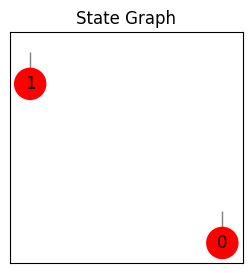

[[0. 0.]
 [0. 0.]]


In [26]:
# Example inital
target_tensor = np.random.randn(4,4)
env = Environment(target_tensor, reward_breakdown=True)
env.plot_adjacency_matrix()
print(env.state)

Plot of State along with the ground truth

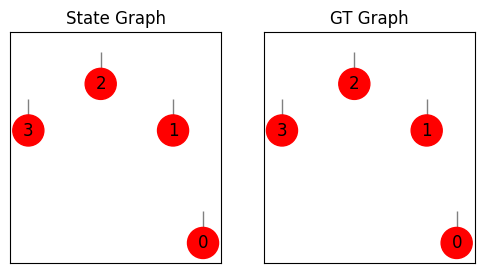

In [27]:
# Example usage (with ground truth visualization)
target_tensor = np.random.randn(4,4, 4, 4)
gt_graph = np.zeros((4, 4))
gt_free_dimensions = np.array([4,4,4,4])
env = Environment(target_tensor, reward_breakdown=True, gt_graph=gt_graph, gt_free_dimensions=gt_free_dimensions)
env.plot_adjacency_matrix()

Plot of TN graph after a random trajectory of 20 time steps

Initial state:


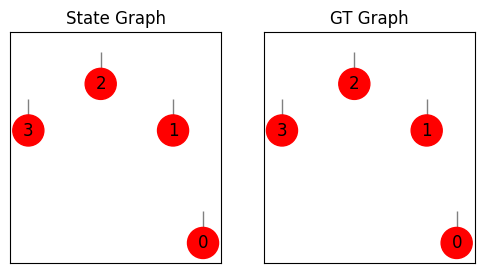

Random agent
State: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

 [0/20] Action: addNode | Reward: -1.20 (loss: 1.20 cr: 0.00) Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


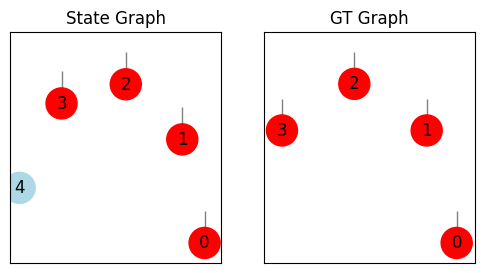

State: 
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

 [1/20] Action: increment:3:4 | Reward: -1.16 (loss: 1.16 cr: 0.00) Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']
State: 
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2.]
 [0. 0. 0. 2. 0.]]

 [2/20] Action: increment:0:4 | Reward: -6.60 (loss: 6.60 cr: 0.00) Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']
State: 
[[0. 0. 0. 0. 2.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2.]
 [2. 0. 0. 2. 0.]]

 [3/20] Action: increment:1:2 | Reward: -2.56 (loss: 2.56 cr: 0.00) Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3',

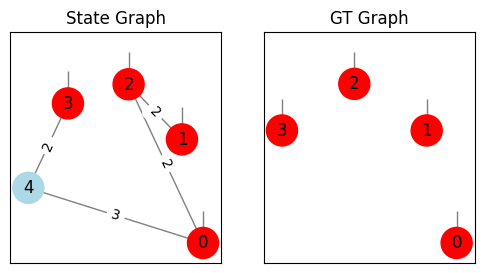

State: 
[[0. 0. 2. 0. 3.]
 [0. 0. 2. 0. 0.]
 [2. 2. 0. 0. 0.]
 [0. 0. 0. 0. 2.]
 [3. 0. 0. 2. 0.]]

 [6/20] Action: increment:2:3 | Reward: -47.10 (loss: 47.10 cr: 0.00) Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']
State: 
[[0. 0. 2. 0. 3.]
 [0. 0. 2. 0. 0.]
 [2. 2. 0. 2. 0.]
 [0. 0. 2. 0. 2.]
 [3. 0. 0. 2. 0.]]

 [7/20] Action: increment:0:3 | Reward: -158.90 (loss: 158.90 cr: 0.00) Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']
State: 
[[0. 0. 2. 2. 3.]
 [0. 0. 2. 0. 0.]
 [2. 2. 0. 2. 0.]
 [2. 0. 2. 0. 2.]
 [3. 0. 0. 2. 0.]]

 [8/20] Action: addNode | Reward: -30.30 (loss: 30.30 cr: 0.00) Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'in

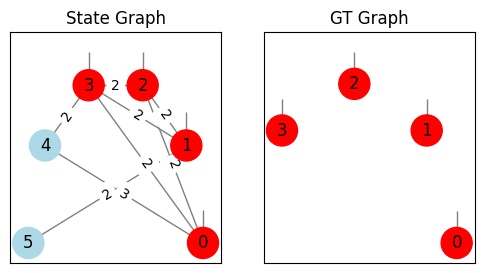

State: 
[[0. 0. 2. 2. 3. 0.]
 [0. 0. 2. 2. 0. 2.]
 [2. 2. 0. 2. 0. 0.]
 [2. 2. 2. 0. 2. 0.]
 [3. 0. 0. 2. 0. 0.]
 [0. 2. 0. 0. 0. 0.]]

 [11/20] Action: increment:2:4 | Reward: -170.35 (loss: 170.35 cr: 0.00) Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:0:5', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:1:5', 'increment:2:3', 'increment:2:4', 'increment:2:5', 'increment:3:4', 'increment:3:5', 'increment:4:5']
State: 
[[0. 0. 2. 2. 3. 0.]
 [0. 0. 2. 2. 0. 2.]
 [2. 2. 0. 2. 2. 0.]
 [2. 2. 2. 0. 2. 0.]
 [3. 0. 2. 2. 0. 0.]
 [0. 2. 0. 0. 0. 0.]]

[Terminated]  [12/20] Action: increment:1:3 | Reward: -101457.91 (loss: 1457.91 cr: 100000.00) Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:0:5', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:1:5', 'increment:2:3', 'increment:2:4', 'increment:2:5', 'increment:3:4', 'increment:3:5', 'increment:4:5']
Resett

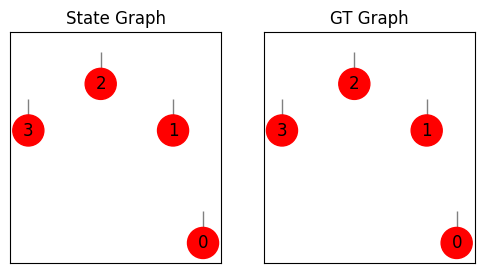

State: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

 [13/20] Action: increment:1:3 | Reward: -1.70 (loss: 1.70 cr: 0.00) Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']
State: 
[[0. 0. 0. 0.]
 [0. 0. 0. 2.]
 [0. 0. 0. 0.]
 [0. 2. 0. 0.]]

 [14/20] Action: increment:1:2 | Reward: -1.12 (loss: 1.12 cr: 0.00) Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']
State: 
[[0. 0. 0. 0.]
 [0. 0. 2. 2.]
 [0. 2. 0. 0.]
 [0. 2. 0. 0.]]

 [15/20] Action: increment:1:3 | Reward: -1.34 (loss: 1.34 cr: 0.00) Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


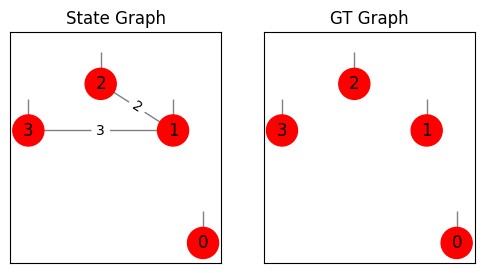

State: 
[[0. 0. 0. 0.]
 [0. 0. 2. 3.]
 [0. 2. 0. 0.]
 [0. 3. 0. 0.]]

 [16/20] Action: increment:1:2 | Reward: -1.59 (loss: 1.59 cr: 0.00) Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']
State: 
[[0. 0. 0. 0.]
 [0. 0. 3. 3.]
 [0. 3. 0. 0.]
 [0. 3. 0. 0.]]

 [17/20] Action: increment:1:3 | Reward: -20.87 (loss: 20.87 cr: 0.00) Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']
State: 
[[0. 0. 0. 0.]
 [0. 0. 3. 4.]
 [0. 3. 0. 0.]
 [0. 4. 0. 0.]]

 [18/20] Action: addNode | Reward: -11.28 (loss: 11.28 cr: 0.00) Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']
State: 
[[0. 0. 0. 0. 0.]
 [0. 0. 3. 4. 0.]
 [0. 3. 0. 0. 0.]
 [0. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

 [19/20] Action: increment:0:1 | Reward: -5.53 (loss: 5.53 cr: 0.00) Feasible: ['increment:0:1', 'increment:0:2',

In [29]:
# Example usage
import random
env.reset()

print("Initial state:")
env.plot_adjacency_matrix()

n_steps = 20
print("Random agent")
for t in range(n_steps):
  print(f"State: \n{env.state}\n")
  actions = env.get_feasible_actions()
  random_action = random.choice(actions)  # Select a random action from the feasible actions
  state, reward, done, truncted, reward_breakdown = env.step_action(random_action)
  print(f"{'[Terminated] ' if done else ''} [{t}/{n_steps}] Action: {random_action} | Reward: {reward:.2f} (loss: {reward_breakdown[0]:.2f} cr: {reward_breakdown[1]:.2f}) Feasible: {actions}")
  if done:
    print("Resetting")
    env.reset()
    env.plot_adjacency_matrix()
    # import pdb; pdb.set_trace()
  elif t % 5 == 0:
    env.plot_adjacency_matrix()

# 2. Training

## 2.1 Utils


In [30]:
def get_tn_params(adj_mat: np.array, free_dims_vec: np.array) -> int:
    """
    Calculate the total number of parameters in a tensor network.

    Parameters:
    adj_mat (numpy.ndarray): Adjacency matrix representing the tensor network.
    free_dims_vec (numpy.ndarray): Vector containing the dimensions of the free legs in the network.

    Returns:
    int: Total number of parameters in the tensor network.
    """

    num_tensors = len(adj_mat)
    total_params = 0

    # Calculate parameters for each tensor
    for i in range(num_tensors):
        # dims = [free_dims_vec[i]] + list(adj_mat[i])
        dims = list(adj_mat[i][adj_mat[i] !=0])
        dims += [free_dims_vec[i]] if i < len(free_dims_vec) and free_dims_vec[i] > 0 else []
        total_params += np.prod(dims)

    return int(total_params)

## 2.2 Agent Base Class

In [31]:
class Agent():
    def __init__(self):
        pass
    def agent_step(self, prev_state, prev_action, prev_reward, current_state, done, feasible_actions):
        """ A learning step for the agent given a state, action, reward, next state and done
        Args:
            prev_state (int): the state observation from the enviromnents last step
            prev_action (int): the action taken given prev_state
            prev_reward (float): The reward received for taking prev_action in prev_state
            current_state (int): The state received for taking prev_action in prev_state
            done (bool): Indicator that the episode is done
        Returns:
            action (int): the action the agent is taking given current_state
        """
        raise NotImplementedError


## 2.2 SARSA agent

In [32]:
class SarsaAgent(Agent):

    def __init__(self, agent_init_info: dict):
        super().__init__()
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.q = dict()

    def current_policy(self, current_state, feasible_actions):
        # Choose a random action with probability epsilon
        if len(self.q) == 0  or np.random.random() < epsilon:
          return random.choice(feasible_actions)

        max = -np.inf
        a_opt = ""
        bo=False

        for qa in self.q:
          if qa[0] == str(current_state) and self.q[qa] > max:
            max = self.q[qa]
            a_opt = qa[1]
            bo=True
        if a_opt == "":
          a_opt = random.choice(feasible_actions)
        return a_opt

    def agent_step(self, prev_state, prev_action, prev_reward, current_state, done, feasible_actions):
        """ A learning step for the agent given SARSA
        Args:
            prev_state (int): the state observation from the enviromnents last step
            prev_action (int): the action taken given prev_state
            prev_reward (float): The reward received for taking prev_action in prev_state
            current_state (int): The state received for taking prev_action in prev_state
            done (bool): Indicator that the episode is done
        Returns:
            action (int): the action the agent is taking given current_state
        """

        action = self.current_policy(current_state, feasible_actions)

        if not (str(prev_state),prev_action) in self.q:
            self.q[(str(prev_state),prev_action)] = 0
        if not  (str(current_state),action) in self.q:
            self.q[(str(current_state),action)] = 0

        if not done:
          # Update Q-value for the previous state-action pair using the SARSA update rule
          self.q[(str(prev_state),prev_action)] += self.step_size * (prev_reward + self.discount *
                                                                     self.q[(str(current_state),action)] - self.q[(str(prev_state),prev_action)])
          #self.q[(str(prev_state),prev_action)] = self.q[(str(prev_state),prev_action)].detach().item()
        else:
          # If the episode is done, update Q-value for the previous state-action pair with terminal reward
          self.q[(str(prev_state),prev_action)] += self.step_size * (prev_reward - self.q[(str(prev_state),prev_action)])
          #self.q[(str(prev_state),prev_action)] = self.q[(str(prev_state),prev_action)].detach().item()
        return action


In [48]:
def train_episode(agent, env):
    """
    Input:
        agent (Agent): an agent of the class Agent implemented above
        env (DiscreteEnv): The FloorIsLava environment
    Returns:
        states (list): the sequence of states in the generated episode
        actions (list): the sequence of actions in the generated episode
        rewards (list): the sequence of rewards in the generated episode
    """
    states = []
    rewards = []
    actions = []
    done = False
    current_state = env.reset()
    states.append(current_state)
    action = agent.current_policy(current_state, env.get_feasible_actions())
    actions.append(action)
    i = 0

    print("Initial State:")
    env.plot_adjacency_matrix()

    while not done:
        i +=1
        feasible_actions = env.get_feasible_actions()
        next_state, reward, truncated, done = env.step_action(action)
        action = agent.agent_step(current_state, action, reward, next_state, done, feasible_actions)
        done = done or truncated
        actions.append(action)
        rewards.append(reward)
        states.append(next_state)
        current_state = next_state
        if i % 2 == 0 or done:
          print(f"{'[Terminated] ' if done else ''}Action: {action} | Reward: {reward} | Feasible: {feasible_actions}")
          env.plot_adjacency_matrix()

    print("-" * 100 + "END OF EPISODE" + "-" * 100)
    return states, actions, rewards

In [52]:
def td_control(env, agent_class, epsilon, step_size, run, num_episodes=100, discount=0.99):
    agent_info = {
      "epsilon": epsilon,
      "step_size": step_size,
      "discount": discount
    }
    agent = agent_class(agent_info)
    all_returns = []

    for j in (range(num_episodes)):
      print(f"Episode: {j+1}/{num_episodes}")
      states, actions, rewards = train_episode(agent, env)
      rewards=torch.tensor(rewards).detach().numpy()
      all_returns.append(np.sum(rewards))
    return all_returns, agent,states[-1]

In [53]:
def get_problem(prob_num=1):

  # Target a (Tucker)
  if prob_num == 1:
    dim_a, dim_b, dim_c, dim_r = 4, 4, 4, 2
    a = np.random.randn(dim_a, dim_r)
    b = np.random.randn(dim_b, dim_r)
    c = np.random.randn(dim_c, dim_r)
    g = np.random.randn(dim_r, dim_r, dim_r)
    target_tensor = np.einsum('ai, bj, ck, ijk->abc', a, b, c, g)
    gt_graph = np.array([
        [0, 0, 0, dim_r],
        [0, 0, 0, dim_r],
        [0, 0, 0, dim_r],
        [dim_r, dim_r, dim_r, 0],
    ])
    gt_free_dimensions = np.array([dim_a, dim_b, dim_c])
    gt_params = get_tn_params(gt_graph, gt_free_dimensions)
    gt_compression = gt_params / np.prod(gt_free_dimensions)
    return target_tensor, gt_graph, gt_free_dimensions, gt_compression

  0%|          | 0/1 [00:00<?, ?it/s]

Episode: 1/50
Initial State:


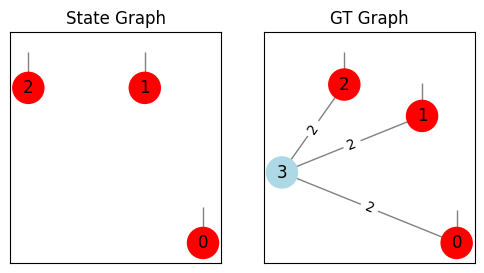

  0%|          | 0/1 [00:01<?, ?it/s]


KeyboardInterrupt: ignored

In [55]:
## Running SARSA on the environment on 5 different seeds

epsilon = 0.2 #@param {allow-input: true}
step_size = 0.1 #@param {allow-input: true}
discount = 0.8 #@param
num_runs =  1 #@param {allow-input: true}
num_episodes = 50 #@param {allow-input: true}

# Setup env
target_tensor, gt_graph, gt_free_dimensions, gt_compression = get_problem(1)
env = Environment(target_tensor, gt_graph=gt_graph, gt_free_dimensions=gt_free_dimensions)

sarsa_returns = []
sarsa_agents = []
for i in tqdm(range(num_runs)):
    returns, agent,last_state = td_control(env, agent_class=SarsaAgent, epsilon=epsilon, step_size=step_size, run=i, num_episodes=num_episodes, discount=discount)
    sarsa_returns.append(returns)
    sarsa_agents.append(agent)

In [ ]:
sarsa_returns

[]

In [ ]:
last_state

NameError: ignored

## 2.3 Q-learning algorithm

In [56]:
#@title Q-learning

class QLearningAgent(Agent):
    def __init__(self, agent_init_info: dict):
      super().__init__()
      self.epsilon = agent_init_info["epsilon"]
      self.step_size = agent_init_info["step_size"]
      self.discount = agent_init_info["discount"]
      self.q = dict()

    def current_policy(self, current_state, feasible_actions):
        # Choose a random action with probability epsilon
        if len(self.q) == 0  or np.random.random() < epsilon:
          return random.choice(feasible_actions)

        max = -np.inf
        a_opt = ""
        bo=False

        for qa in self.q:
          if qa[0] == str(current_state) and self.q[qa] > max:
            max = self.q[qa]
            a_opt = qa[1]
            bo=True
        if a_opt == "":
          a_opt = random.choice(feasible_actions)
        return a_opt

    def agent_step(self, prev_state, prev_action, prev_reward, current_state, done, feasible_actions):
        """ A learning step for the agent given SARS
        Args:
            prev_state (int): the state observation from the enviromnents last step
            prev_action (int): the action taken given prev_state
            prev_reward (float): The reward received for taking prev_action in prev_state
            current_state (int): The state received for taking prev_action in prev_state
            done (bool): Indicator that the episode is done
        Returns:
            action (int): the action the agent is taking given current_state
        """
        # action = self.get_current_policy()(current_state)
        action = self.current_policy(current_state, feasible_actions)

        if not (str(prev_state),prev_action) in self.q:
            self.q[(str(prev_state),prev_action)] = 0
        if not  (str(current_state),action) in self.q:
            self.q[(str(current_state),action)] = 0

        max = -np.inf

        for qa in self.q:
          if qa[0] == str(current_state) and self.q[qa] > max:
            max = self.q[qa]

        if not done:
            # Update Q-value for the previous state-action pair using the Q-learning update rule
            self.q[(str(prev_state),prev_action)] += self.step_size * (prev_reward + self.discount * max - self.q[(str(prev_state),prev_action)])
        else:
            # If the episode is done, update Q-value for the previous state-action pair with terminal reward
            self.q[(str(prev_state),prev_action)] += self.step_size * (prev_reward - self.q[(str(prev_state),prev_action)])


        return action

Episode: 1/50
Initial State:


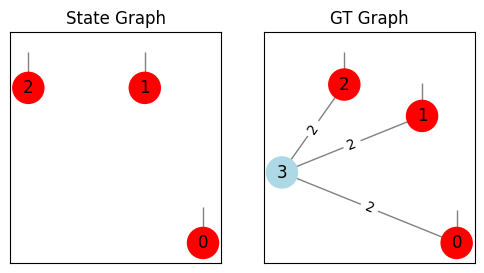

Action: increment:0:1 | Reward: -6.53055995994499 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:1:2']


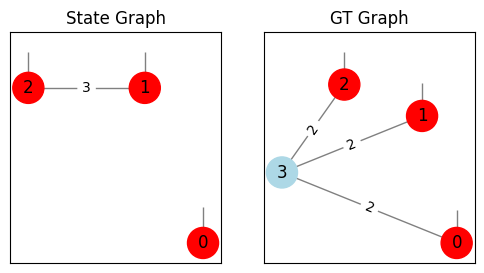

Action: addNode | Reward: -28.72831414291049 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:1:2']


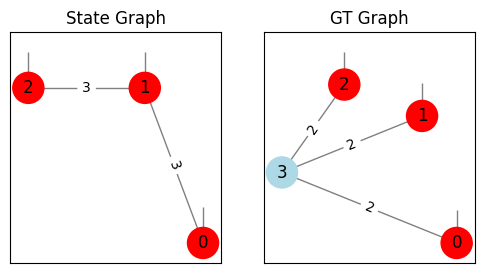

[Terminated] Action: increment:0:3 | Reward: -100013.15525681958 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


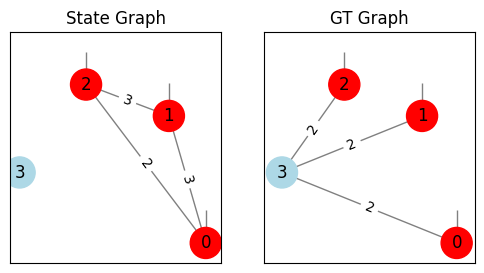

----------------------------------------------------------------------------------------------------END OF EPISODE----------------------------------------------------------------------------------------------------
Episode: 2/50
Initial State:


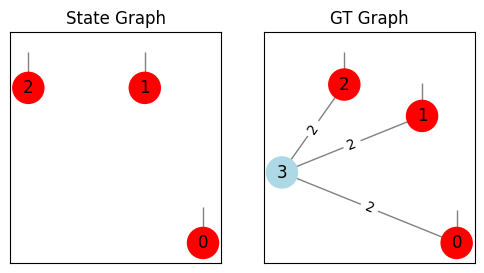

Action: addNode | Reward: -6.180775129491005 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:1:2']


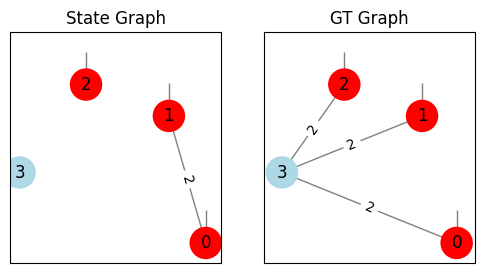

Action: increment:0:3 | Reward: -2.3570378275526194 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


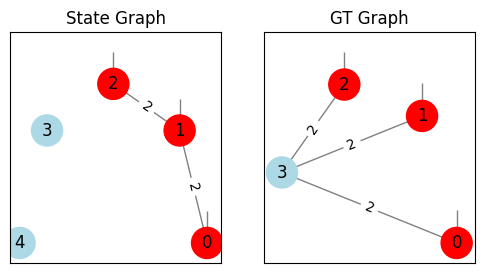

Action: increment:2:4 | Reward: -3.004145975207521 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


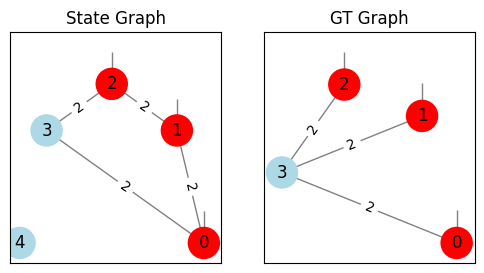

[Terminated] Action: increment:0:3 | Reward: -100036.33635780029 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


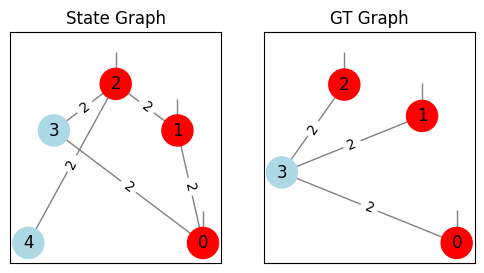

----------------------------------------------------------------------------------------------------END OF EPISODE----------------------------------------------------------------------------------------------------
Episode: 3/50
Initial State:


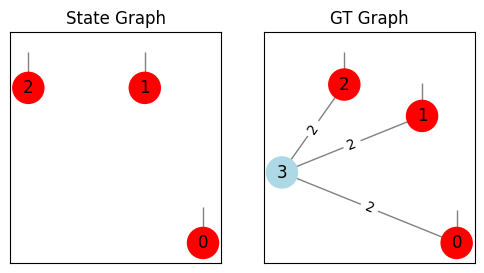

Action: increment:2:3 | Reward: -1.0682861836563944 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


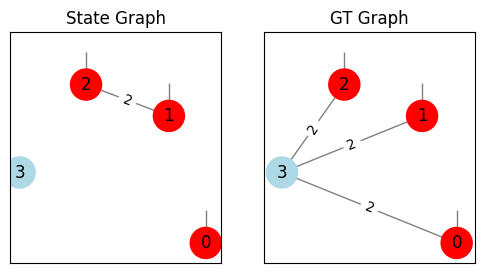

Action: increment:2:3 | Reward: -6.688679784061967 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


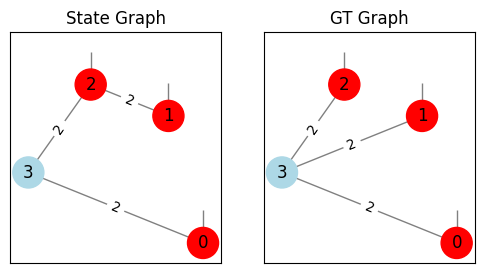

[Terminated] Action: increment:1:2 | Reward: -100005.41803735946 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


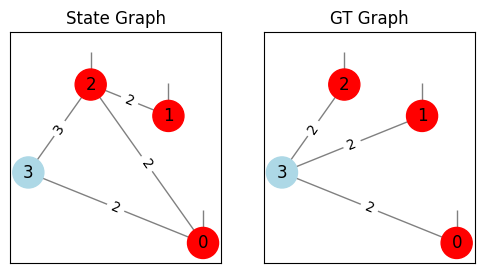

----------------------------------------------------------------------------------------------------END OF EPISODE----------------------------------------------------------------------------------------------------
Episode: 4/50
Initial State:


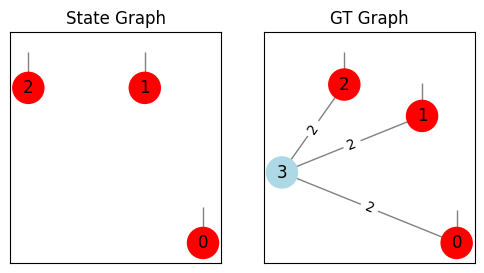

Action: increment:2:3 | Reward: -1.1679209993455693 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


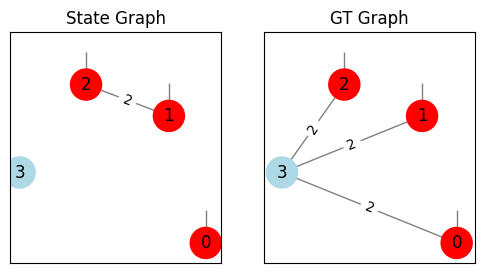

Action: increment:1:2 | Reward: -2.515254068075072 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


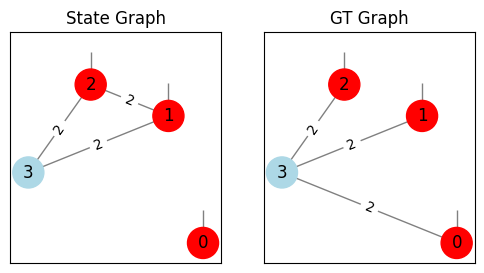

[Terminated] Action: increment:0:1 | Reward: -100002.93405143871 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


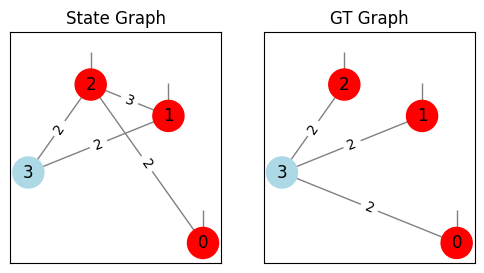

----------------------------------------------------------------------------------------------------END OF EPISODE----------------------------------------------------------------------------------------------------
Episode: 5/50
Initial State:


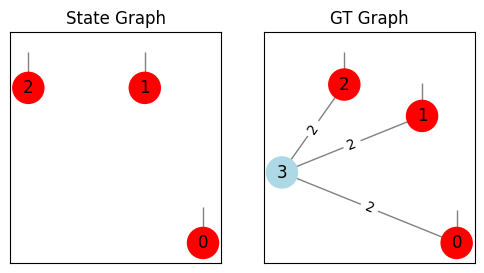

Action: increment:2:3 | Reward: -3.3727528872769255 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


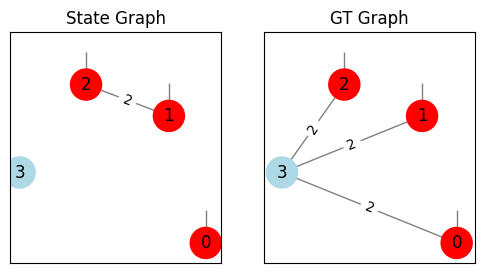

Action: increment:1:2 | Reward: -3.05993095307513 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


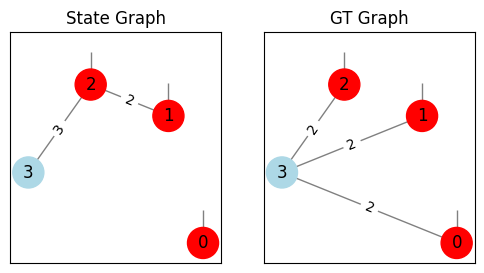

[Terminated] Action: increment:0:1 | Reward: -100004.63777871702 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


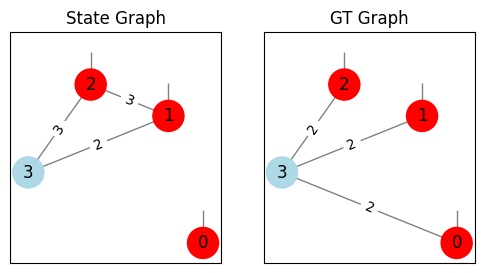

----------------------------------------------------------------------------------------------------END OF EPISODE----------------------------------------------------------------------------------------------------
Episode: 6/50
Initial State:


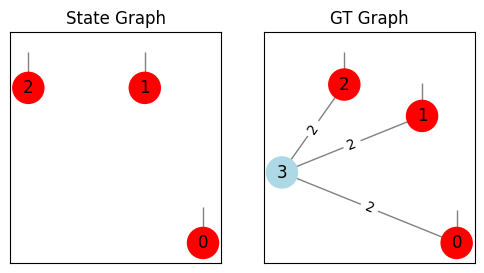

Action: increment:2:3 | Reward: -0.6699470255241855 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


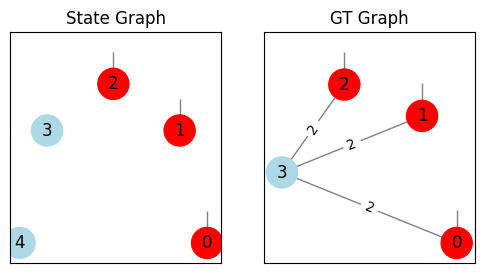

Action: increment:0:3 | Reward: -1.8534684216235098 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


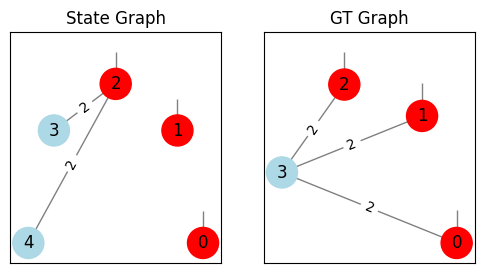

Action: increment:0:3 | Reward: -1.1518920614222101 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


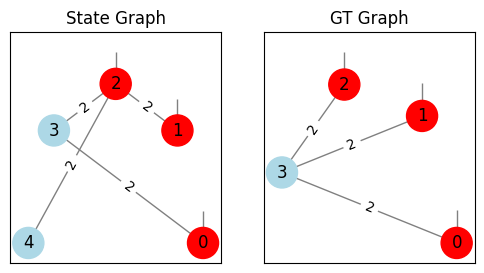

[Terminated] Action: increment:1:2 | Reward: -100005.67724166604 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


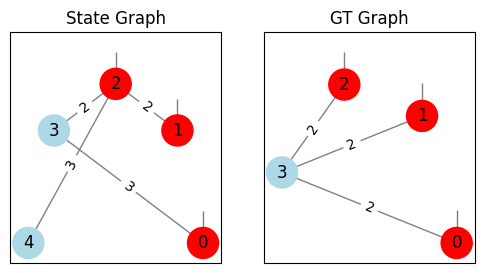

----------------------------------------------------------------------------------------------------END OF EPISODE----------------------------------------------------------------------------------------------------
Episode: 7/50
Initial State:


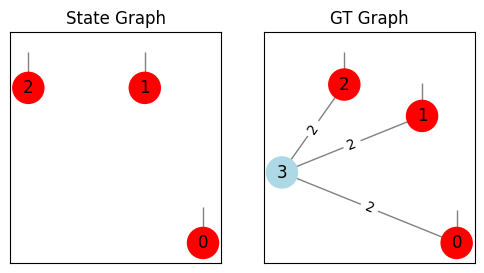

Action: increment:2:3 | Reward: -0.7763023910254023 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


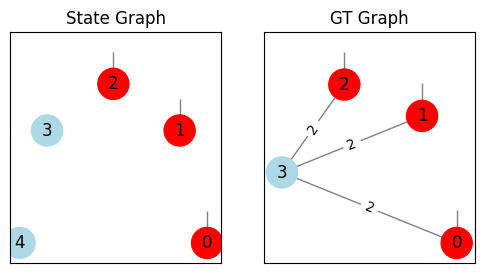

Action: increment:0:3 | Reward: -1.8386537429595675 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


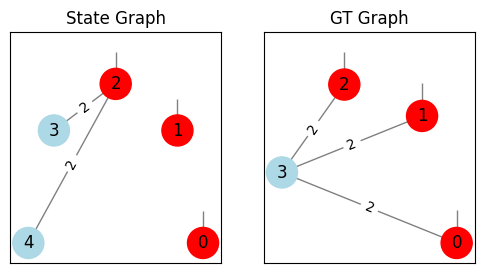

Action: increment:1:2 | Reward: -5.699258222208416 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


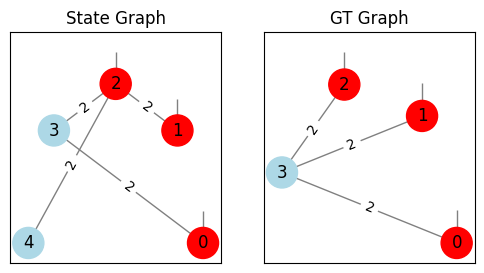

[Terminated] Action: addNode | Reward: -100036.34404160875 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


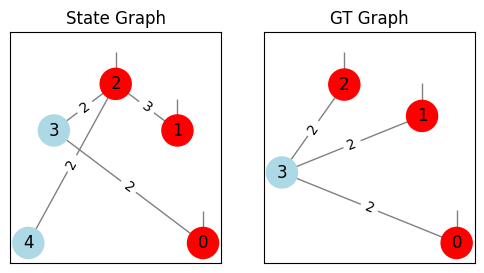

----------------------------------------------------------------------------------------------------END OF EPISODE----------------------------------------------------------------------------------------------------
Episode: 8/50
Initial State:


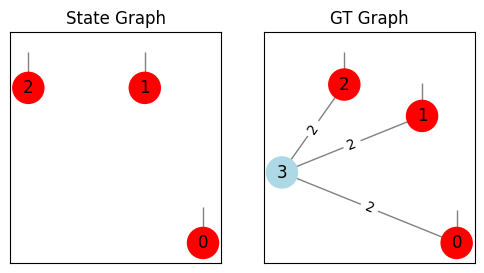

Action: increment:0:1 | Reward: -2.190879204501041 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:1:2']


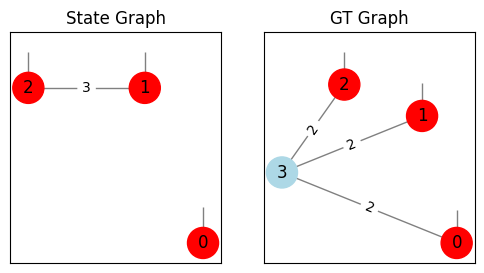

Action: addNode | Reward: -6.223994694875934 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:1:2']


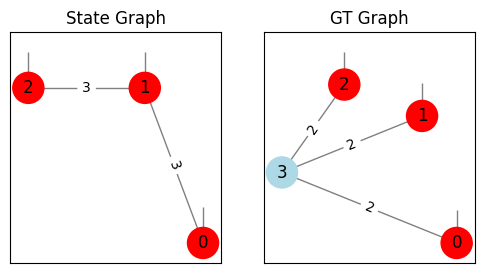

[Terminated] Action: increment:0:3 | Reward: -100014.89818291306 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


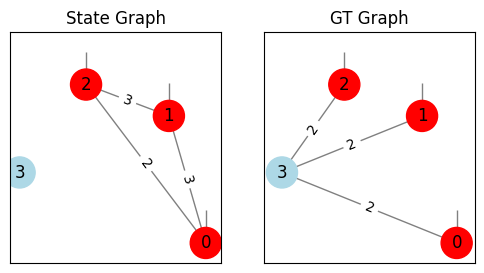

----------------------------------------------------------------------------------------------------END OF EPISODE----------------------------------------------------------------------------------------------------
Episode: 9/50
Initial State:


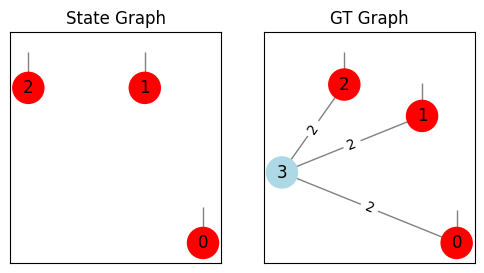

Action: increment:2:3 | Reward: -0.8178917668390251 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


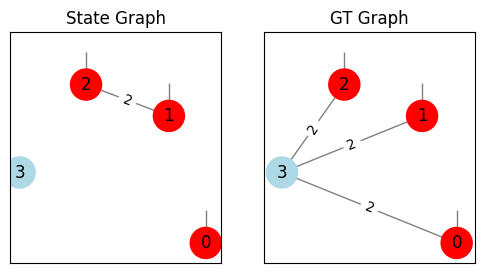

Action: increment:0:3 | Reward: -19.563824968309326 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


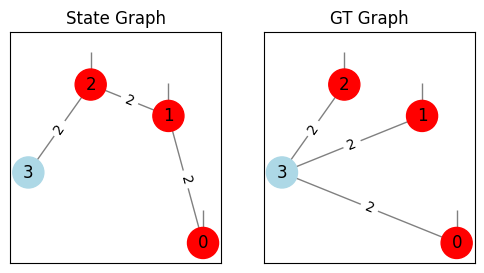

[Terminated] Action: increment:2:3 | Reward: -100052.19246968311 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


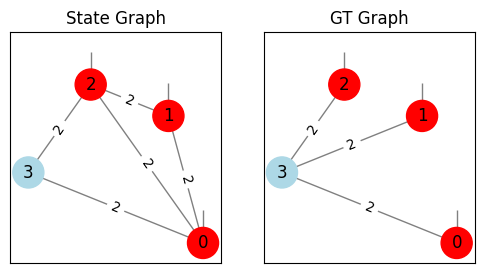

----------------------------------------------------------------------------------------------------END OF EPISODE----------------------------------------------------------------------------------------------------
Episode: 10/50
Initial State:


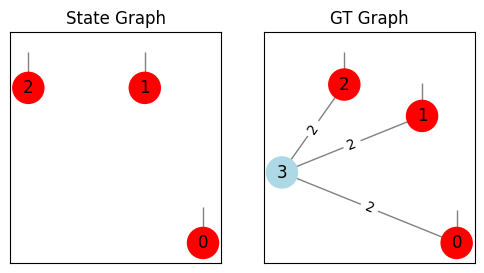

Action: increment:2:3 | Reward: -0.6747841287251128 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


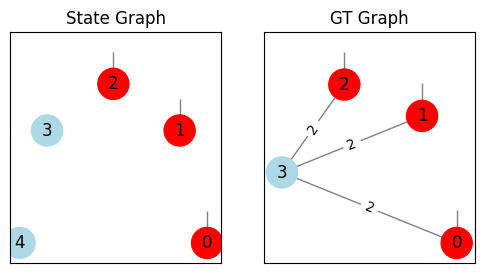

Action: increment:0:1 | Reward: -37.07904678288612 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


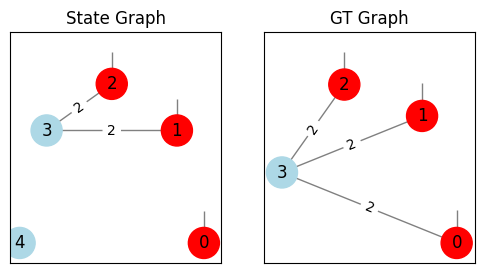

Action: increment:2:4 | Reward: -15.394349969259292 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


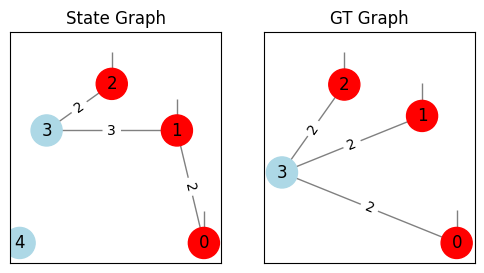

[Terminated] Action: increment:2:4 | Reward: -100078.59641123874 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


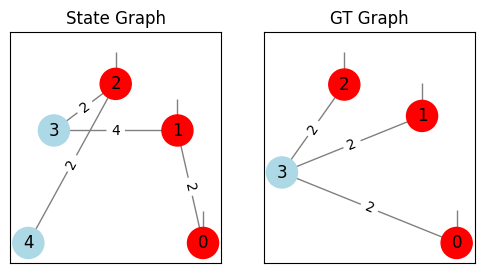

----------------------------------------------------------------------------------------------------END OF EPISODE----------------------------------------------------------------------------------------------------
Episode: 11/50
Initial State:


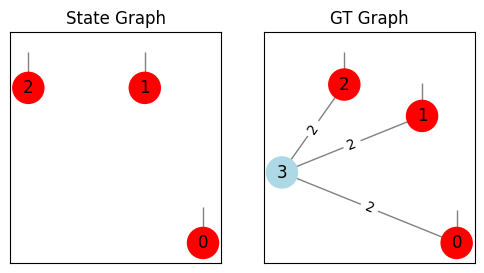

Action: increment:2:3 | Reward: -0.8702586476695497 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


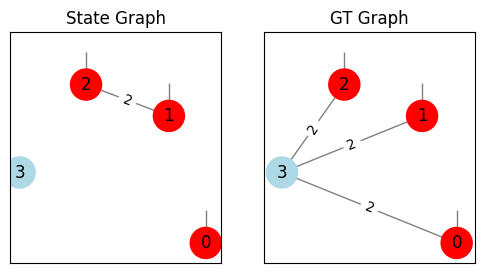

Action: increment:1:2 | Reward: -58.959175412629975 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


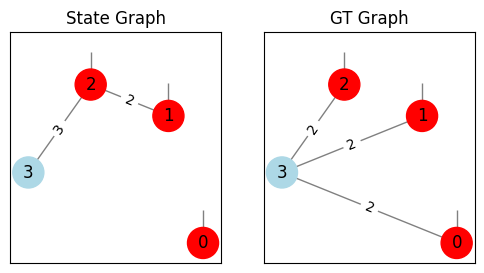

Action: increment:1:3 | Reward: -11.26983814509376 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


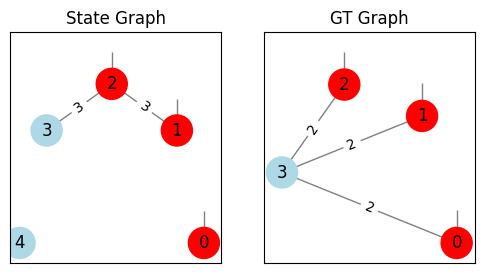

[Terminated] Action: increment:0:3 | Reward: -100055.45163325449 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


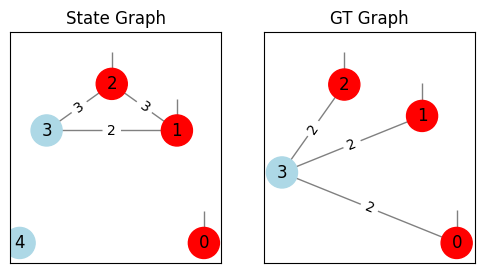

----------------------------------------------------------------------------------------------------END OF EPISODE----------------------------------------------------------------------------------------------------
Episode: 12/50
Initial State:


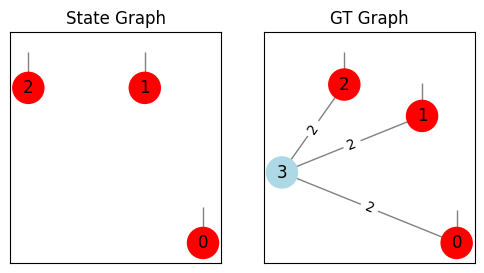

Action: increment:2:3 | Reward: -2.2763184242777377 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


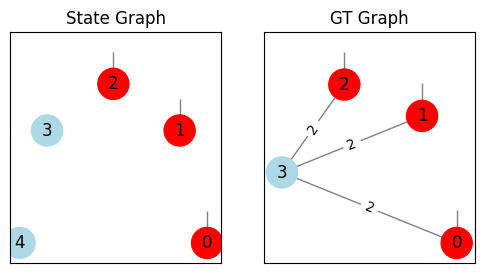

Action: increment:0:3 | Reward: -2.050189803887127 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


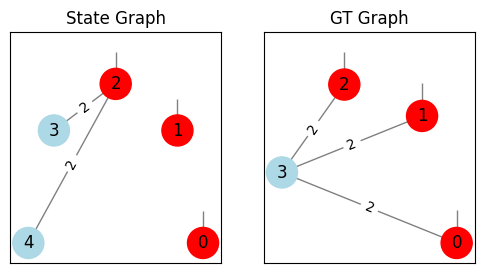

Action: increment:0:3 | Reward: -10.952194553491582 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


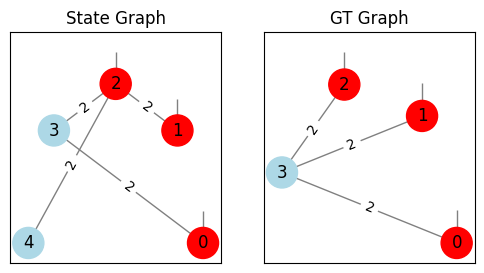

[Terminated] Action: increment:1:4 | Reward: -100001.35566988659 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


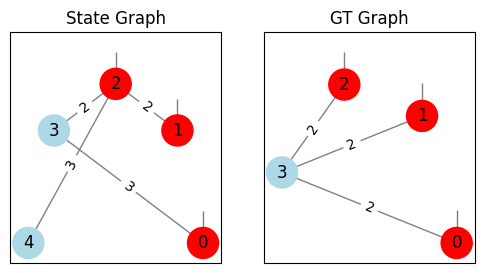

----------------------------------------------------------------------------------------------------END OF EPISODE----------------------------------------------------------------------------------------------------
Episode: 13/50
Initial State:


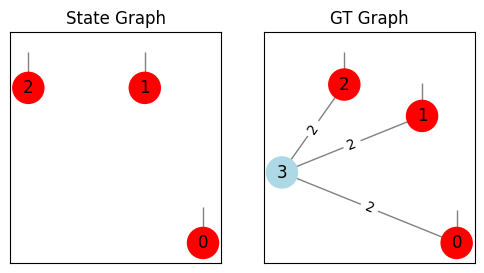

Action: increment:0:2 | Reward: -0.8971543660730192 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


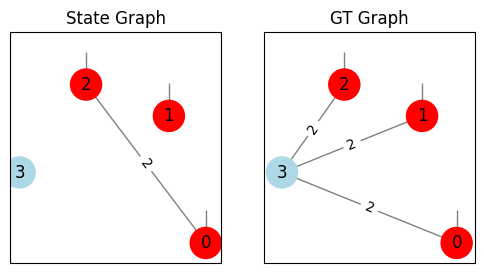

Action: increment:0:3 | Reward: -5.858730031578885 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


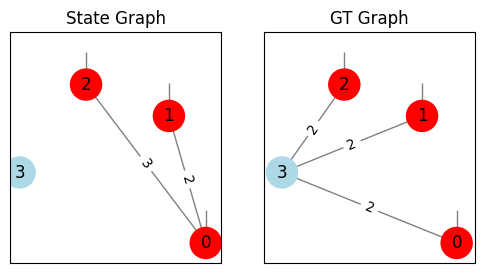

[Terminated] Action: increment:2:3 | Reward: -100004.21498299782 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


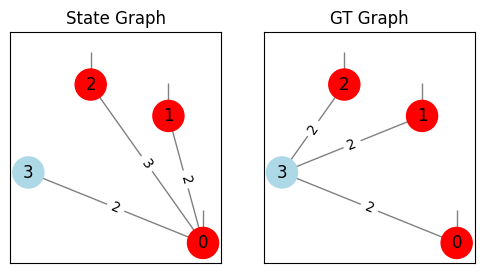

----------------------------------------------------------------------------------------------------END OF EPISODE----------------------------------------------------------------------------------------------------
Episode: 14/50
Initial State:


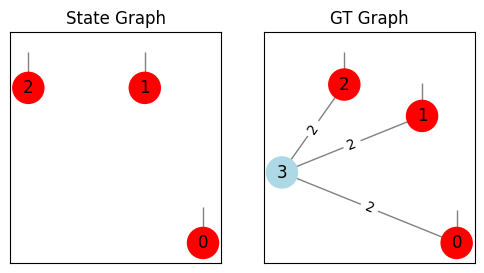

Action: increment:1:2 | Reward: -0.9146326938422757 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


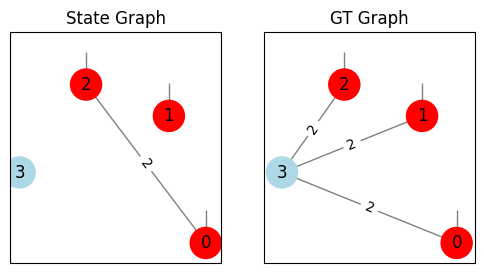

Action: increment:0:2 | Reward: -1.244969123905456 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


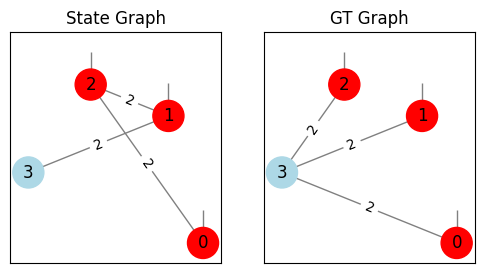

Action: addNode | Reward: -8.659413450040073 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


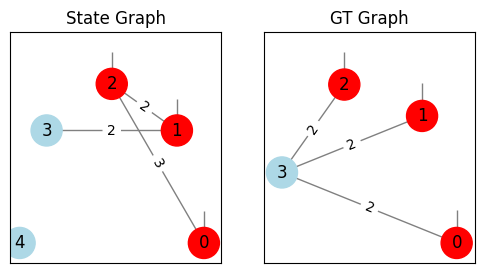

[Terminated] Action: increment:4:5 | Reward: -100008.84922178347 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:0:5', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:1:5', 'increment:2:3', 'increment:2:4', 'increment:2:5', 'increment:3:4', 'increment:3:5', 'increment:4:5']


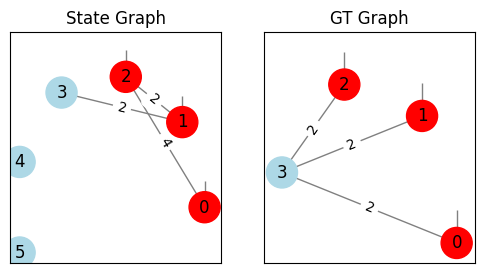

----------------------------------------------------------------------------------------------------END OF EPISODE----------------------------------------------------------------------------------------------------
Episode: 15/50
Initial State:


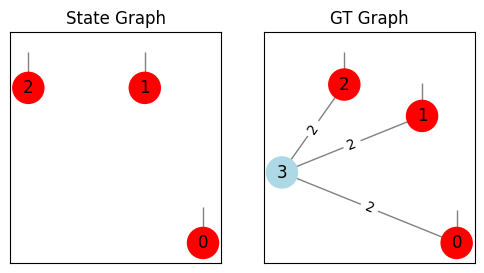

Action: increment:0:2 | Reward: -0.9017466893102066 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:1:2']


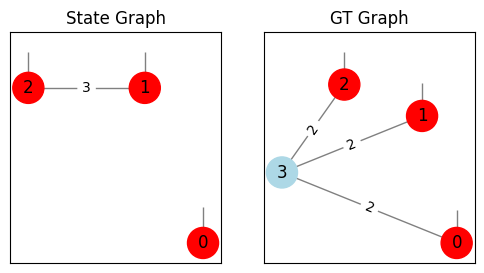

Action: addNode | Reward: -3.960995077289666 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:1:2']


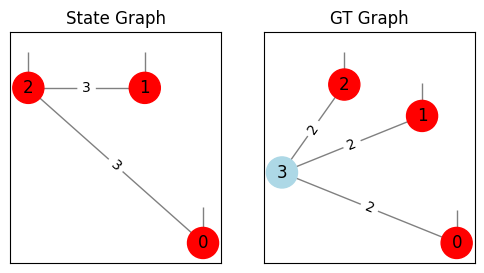

Action: increment:0:2 | Reward: -2.8257816171256924 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


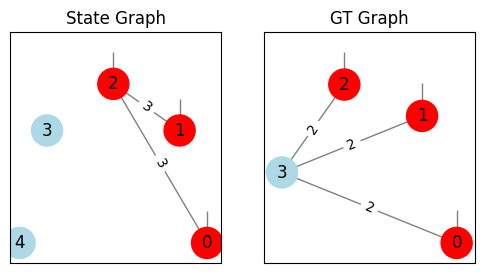

[Terminated] Action: increment:2:3 | Reward: -100006.31566744408 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


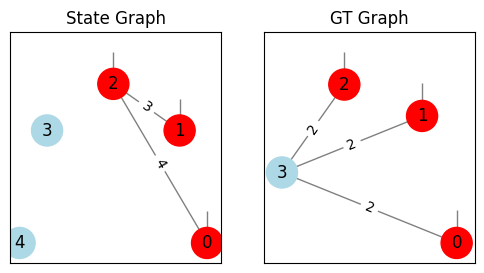

----------------------------------------------------------------------------------------------------END OF EPISODE----------------------------------------------------------------------------------------------------
Episode: 16/50
Initial State:


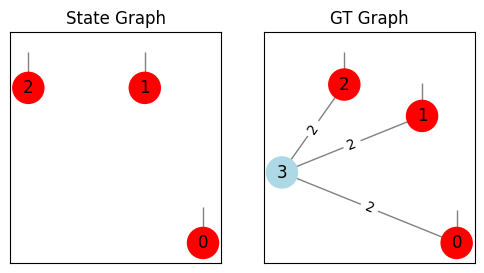

Action: addNode | Reward: -0.8254286219550961 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:1:2']


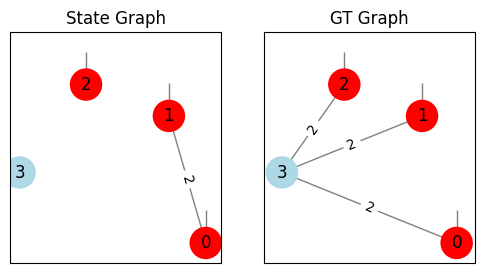

Action: increment:0:3 | Reward: -10.339747608015083 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


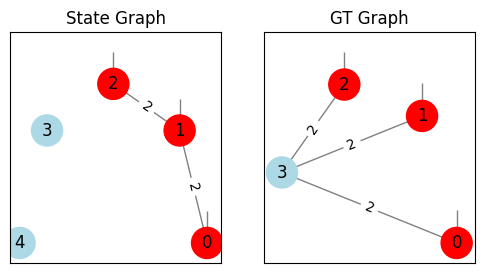

Action: increment:0:3 | Reward: -1.9852486403122178 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


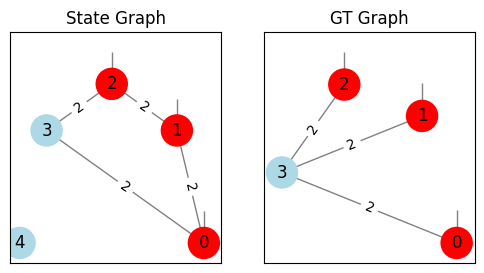

[Terminated] Action: increment:1:4 | Reward: -100022.0218550578 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


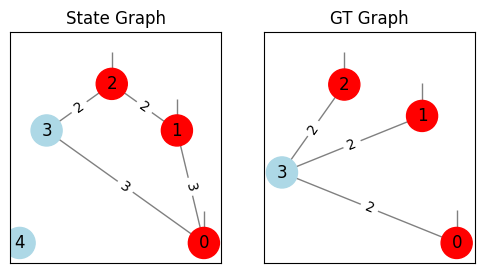

----------------------------------------------------------------------------------------------------END OF EPISODE----------------------------------------------------------------------------------------------------
Episode: 17/50
Initial State:


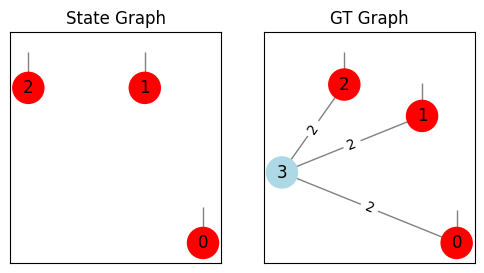

Action: increment:1:2 | Reward: -12.145174903060866 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:1:2']


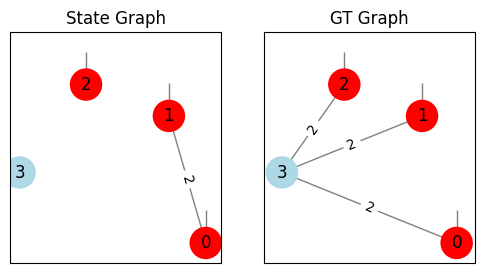

Action: increment:1:2 | Reward: -5.133446334878369 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


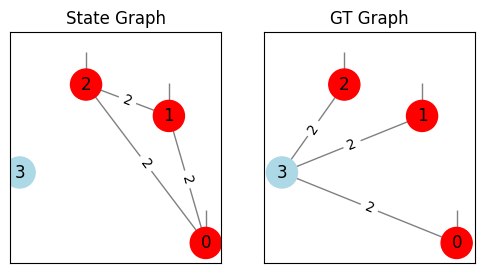

[Terminated] Action: increment:0:2 | Reward: -100004.01250256368 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


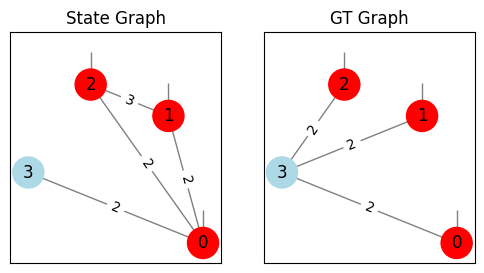

----------------------------------------------------------------------------------------------------END OF EPISODE----------------------------------------------------------------------------------------------------
Episode: 18/50
Initial State:


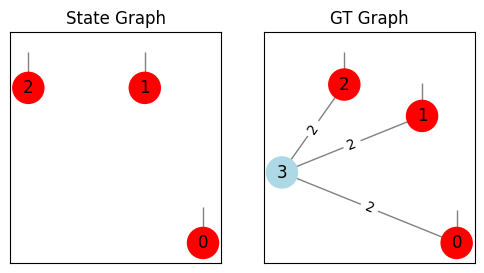

Action: addNode | Reward: -1.0743114608545268 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:1:2']


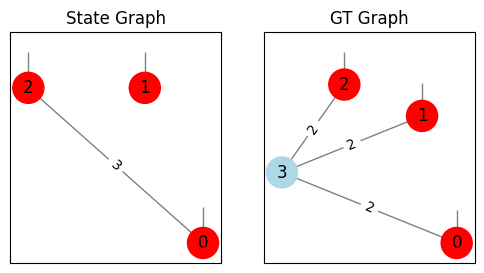

Action: increment:0:3 | Reward: -5.393576606124809 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:1:2', 'increment:1:3', 'increment:2:3']


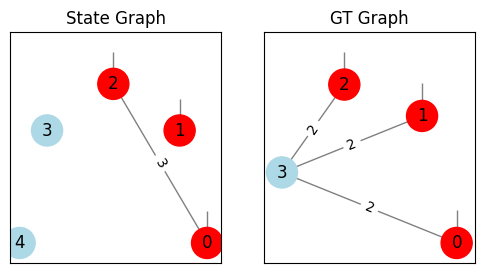

[Terminated] Action: increment:0:1 | Reward: -100034.20710382915 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


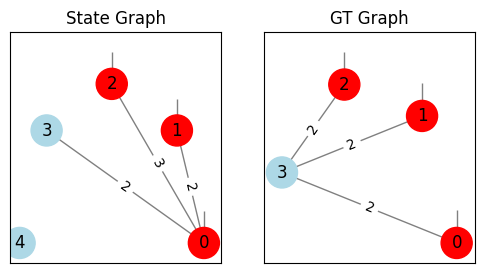

----------------------------------------------------------------------------------------------------END OF EPISODE----------------------------------------------------------------------------------------------------
Episode: 19/50
Initial State:


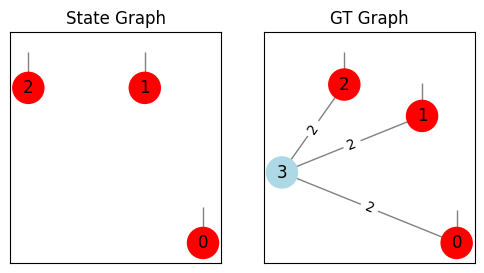

Action: increment:0:1 | Reward: -2.7850094171453437 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:1:2']


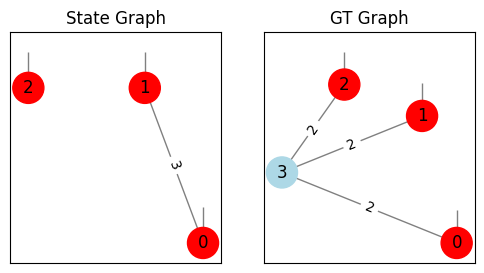

Action: addNode | Reward: -4.321314017718862 | Feasible: ['addNode', 'increment:0:1', 'increment:0:2', 'increment:1:2']


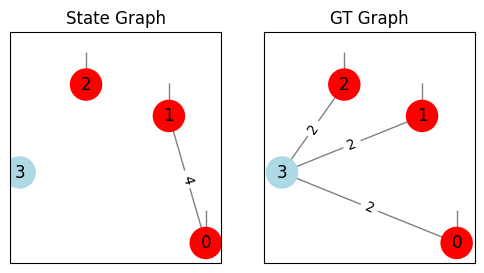

Action: increment:0:1 | Reward: -26.537510047958115 | Feasible: ['increment:0:1', 'increment:0:2', 'increment:0:3', 'increment:0:4', 'increment:1:2', 'increment:1:3', 'increment:1:4', 'increment:2:3', 'increment:2:4', 'increment:3:4']


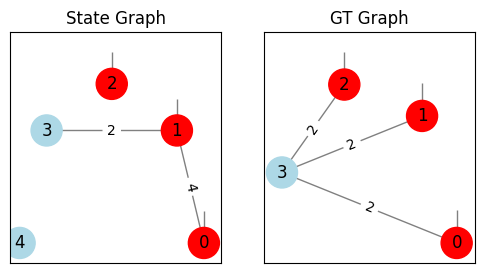

In [ ]:
## Running Q-learning on the environment on 5 different seeds

epsilon = 0.5 #@param {allow-input: true}
step_size = 0.1 #@param {allow-input: true}
discount = 0.99 #@param
num_runs =  10 #@param {allow-input: true}
num_episodes = 50 #@param {allow-input: true}

# Setup env
target_tensor, gt_graph, gt_free_dimensions, gt_compression = get_problem(1)
env = Environment(target_tensor, gt_graph=gt_graph, gt_free_dimensions=gt_free_dimensions)

q_returns = []
q_agents = []
for i in range(num_runs):
    returns, agent, last_state = td_control(env, agent_class=QLearningAgent, epsilon=epsilon, step_size=step_size, run=i, num_episodes=num_episodes, discount=discount)
    q_returns.append(returns)
    q_agents.append(agent)

In [ ]:
last_state